In [1]:
!git clone https://github.com/xinntao/ESRGAN.git
%cd ESRGAN
!pip install facexlib basicsr
!pip install gfpgan 


Cloning into 'ESRGAN'...
remote: Enumerating objects: 225, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 225 (delta 15), reused 14 (delta 14), pack-reused 205 (from 1)
Receiving objects: 100% (225/225), 24.86 MiB | 50.71 MiB/s, done.
Resolving deltas: 100% (85/85), done.
/kaggle/working/ESRGAN
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.9 MB/s eta 0:00:00
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import sys
sys.path.append('/kaggle/working/ESRGAN')
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from RRDBNet_arch import RRDBNet

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/model/pytorch/default/1/model.py
/kaggle/input/rrdb_esrgan_x4.pth/pytorch/default/1/RRDB_ESRGAN_x4 (1).pth
/kaggle/input/animal-image-dataset-90-different-animals/name of the animals.txt
/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/beetle/687486f1cb.jpg
/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/beetle/93fb82b04b.jpg
/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/beetle/7d7f6c9750.jpg
/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/beetle/0de750893f.jpg
/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/beetle/2fecd5e844.jpg
/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/beetle/514cd025fa.jpg
/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/beetle/44931701fe.jpg
/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/beetle/138f5c986e.jpg
/kaggle/input/animal-image-dataset-90-different

In [3]:
from pathlib import Path
import os

input_root = Path('/kaggle/input/animal-image-dataset-90-different-animals/animals/animals')
output_root = Path('/kaggle/working/upscaled_animals')
output_root.mkdir(parents=True, exist_ok=True)


In [4]:
model = RRDBNet(in_nc=3, out_nc=3, nf=64, nb=23, gc=32)
model_path = '/kaggle/input/rrdb_esrgan_x4.pth/pytorch/default/1/RRDB_ESRGAN_x4 (1).pth'
state_dict = torch.load(model_path, map_location='cpu')
model.load_state_dict(state_dict, strict=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()


/tmp/ipykernel_31/942362220.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location='cpu')


RRDBNet(
  (conv_first): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (RRDB_trunk): Sequential(
    (0): RRDB(
      (RDB1): ResidualDenseBlock_5C(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv3): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv4): Conv2d(160, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv5): Conv2d(192, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (lrelu): LeakyReLU(negative_slope=0.2, inplace=True)
      )
      (RDB2): ResidualDenseBlock_5C(
        (conv1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(96, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv3): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv4): Conv2d(160, 32, kernel_size=(3, 3), str

In [5]:
def preprocess(image_path, device):
    image = Image.open(image_path).convert('RGB')
    image = image.resize((128,128), Image.BICUBIC)
    transform = transforms.ToTensor()
    image_tensor = transform(image).unsqueeze(0).to(device) 

    return image_tensor


In [6]:
from torchvision.utils import save_image
from tqdm import tqdm
import time
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

total_time = 0.0
image_count = 0

torch.cuda.reset_peak_memory_stats(device)
animal_dirs = sorted([d for d in input_root.iterdir() if d.is_dir()])[:20]

for animal_dir in tqdm(animal_dirs, desc="Upscaling Images"):
    output_class_dir = output_root / animal_dir.name
    output_class_dir.mkdir(parents=True, exist_ok=True)

    for image_path in animal_dir.glob('*.jpg'):
        try:
            low_res_image = preprocess(image_path, device)
            torch.cuda.synchronize()
            start = time.time()

            with torch.no_grad():
                sr_image = model(low_res_image).clamp(0, 1)
            torch.cuda.synchronize()
            end = time.time()
            total_time += (end - start)
            image_count += 1
            save_path = output_class_dir / image_path.with_suffix('.png').name
            save_image(sr_image, save_path)
            torch.cuda.empty_cache()
        except Exception as e:
            print(f"Error with {image_path}: {e}")
print(f"\nProcessed {image_count} images.")
print(f"Total GPU inference time: {total_time:.2f} seconds")
print(f"Average time per image: {total_time / image_count:.4f} seconds")
allocated = torch.cuda.max_memory_allocated(device) / 1024**2  
reserved = torch.cuda.max_memory_reserved(device) / 1024**2    
print(f"Max GPU memory allocated: {allocated:.2f} MB")
print(f"Max GPU memory reserved : {reserved:.2f} MB")


Upscaling Images: 100%|██████████| 20/20 [05:27<00:00, 16.38s/it]


Processed 1200 images.
Total GPU inference time: 173.36 seconds
Average time per image: 0.1445 seconds
Max GPU memory allocated: 216.40 MB
Max GPU memory reserved : 268.00 MB


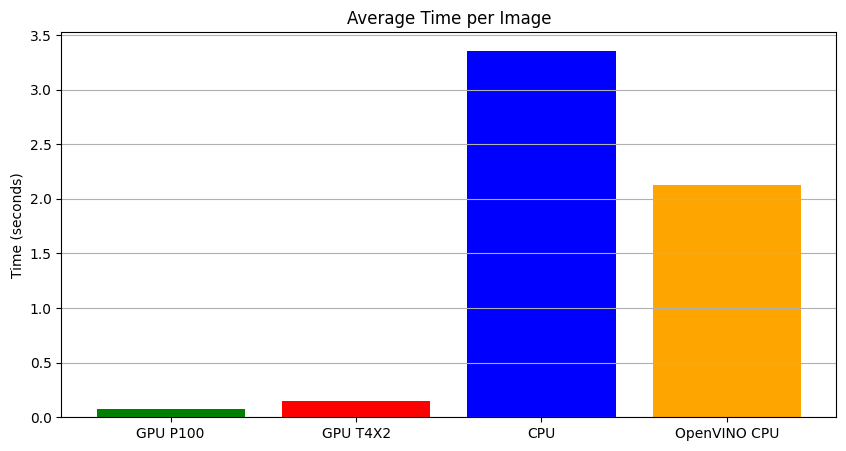

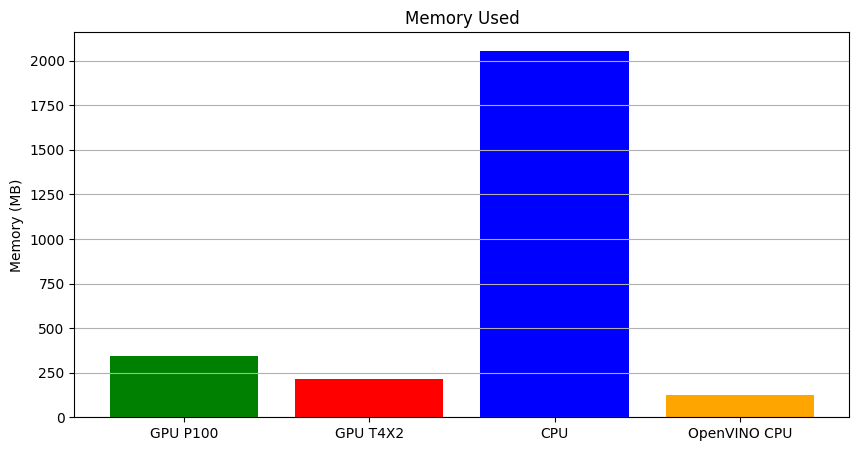

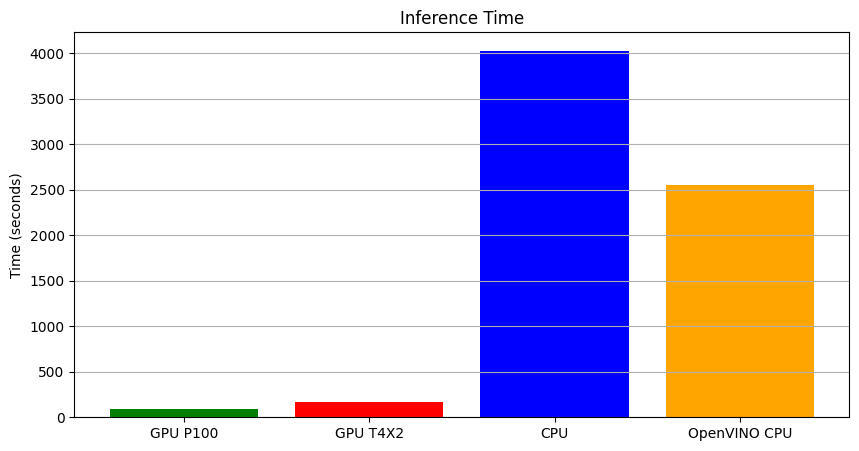

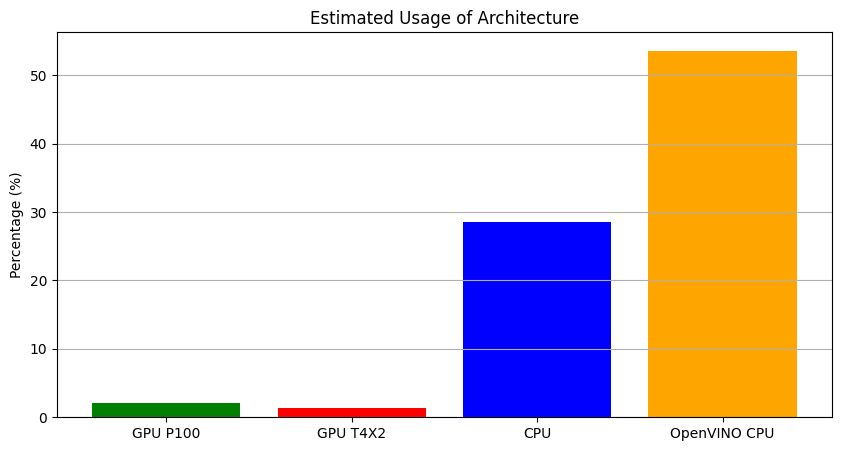

In [6]:
import matplotlib.pyplot as plt

implementations = ['GPU P100', 'GPU T4X2', 'CPU', 'OpenVINO CPU']
avg_time = [0.0780,0.1445, 3.3577, 2.1280]
inference_time = [93.65, 173.36, 4029.23, 2553.6]
memory_used = [344.03, 216.4, 2057.01, 123.68]
Usage_percent = [2.10, 1.32, 28.60, 53.60]
plt.figure(figsize=(10, 5))
plt.bar(implementations, avg_time, color=['green', 'red','blue', 'orange'])
plt.title('Average Time per Image')
plt.ylabel('Time (seconds)')
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(implementations, memory_used, color=['green', 'red','blue', 'orange'])
plt.title('Memory Used')
plt.ylabel('Memory (MB)')
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(implementations, inference_time, color=['green', 'red','blue', 'orange'])
plt.title('Inference Time')
plt.ylabel('Time (seconds)')
plt.grid(axis='y')
plt.show()


plt.figure(figsize=(10, 5))
plt.bar(implementations, Usage_percent, color=['green', 'red','blue', 'orange'])
plt.title('Estimated Usage of Architecture')
plt.ylabel('Percentage (%)')
plt.grid(axis='y')
plt.show()
